# Analysis of latent representation of a CNN autoencoder architecture.

We will consider the encoder output of a trained CNN autoencoder. Our goal is to provide visual intuition to what the encoder is producing.

The training functionalities are based on https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py .The changes to the original code allow for training either the full autoencoder or just the classifier head.

This notebook is divided to the following sections
1. Data preparation. We will use 5 out of 10 classes from FashionMNIST dataset.
2. Train the autoencoder. We will save the network after each epoch.
3. Analyze the output of the encoder after training.
4. Train the classifier.
5. Analyze the results of the trained network.

In [1]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import utils, model_classes, engine

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device = }")

device = 'cuda'


## 1. Prepare data.

We use the following to select specific classes from FashionMNIST
https://stackoverflow.com/questions/63975130/how-to-get-only-specific-classes-from-pytorchs-fashionmnist-dataset

In [3]:
# Download full data
train_dataset = torchvision.datasets.FashionMNIST(
    root = "data", 
    train = True, 
    download = True, 
    transform = torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(
    root = "data", 
    train = False, 
    download = True, 
    transform = torchvision.transforms.ToTensor())

class_names = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
print("Classes and corresponding indices:")
class_to_idx

Classes and corresponding indices:


{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

We will select the following classes for further analysis:
* 'T-shirt/top': 0,
* 'Trouser': 1,
* 'Pullover': 2,
* 'Sneaker': 7,
* 'Bag': 8.

We pick 5 out of 10 classes to reduce complexity of the problem. Later we will plot the model classes in terms of two selected encoder outputs, with too much classes the plots might be not interpretable.

In [4]:
# Filter training dataset
# Code from https://stackoverflow.com/questions/63975130/how-to-get-only-specific-classes-from-pytorchs-fashionmnist-dataset
idx = (train_dataset.targets==0) | (train_dataset.targets==1) | (train_dataset.targets==2) | (train_dataset.targets==7) | (train_dataset.targets==8)
train_dataset.targets = train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]
# Filter testing dataset
idx = (test_dataset.targets==0) | (test_dataset.targets==1) | (test_dataset.targets==2) | (test_dataset.targets==7) | (test_dataset.targets==8)
test_dataset.targets = test_dataset.targets[idx]
test_dataset.data = test_dataset.data[idx]

# Rename targets in train_dataset to be in set [0, 1, 2, 3, 4]
for idx in range(len(train_dataset.targets)):
    if train_dataset.targets[idx] == 7:
        train_dataset.targets[idx] = 3
    elif train_dataset.targets[idx] == 8:
        train_dataset.targets[idx] = 4

# Rename targets in test_dataset to be in set [0, 1, 2, 3, 4]
for idx in range(len(test_dataset.targets)):
    if test_dataset.targets[idx] == 7:
        test_dataset.targets[idx] = 3
    elif test_dataset.targets[idx] == 8:
        test_dataset.targets[idx] = 4
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Sneaker', 'Bag']

print(f"Number of samples in training dataset: {len(train_dataset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")

Number of samples in training dataset: 30000
Number of samples in test dataset: 5000


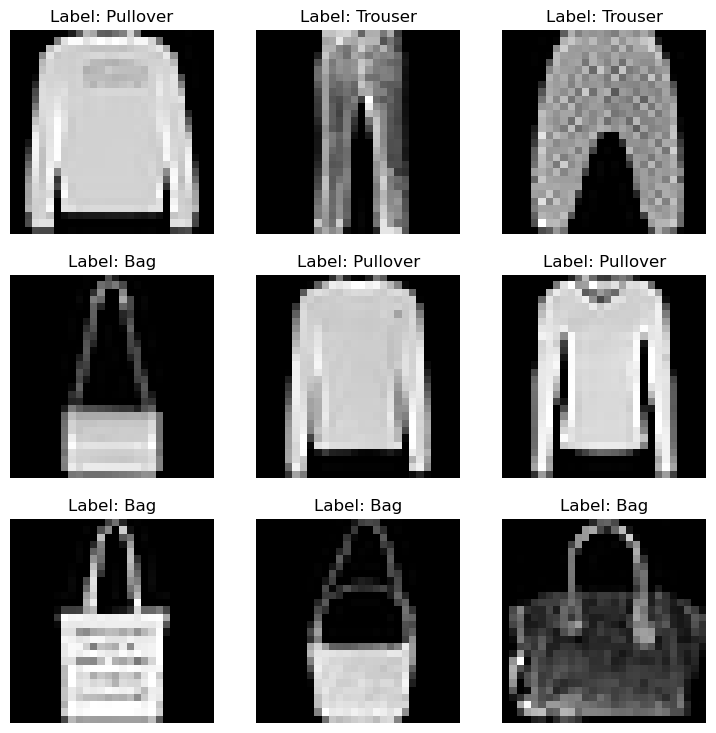

In [5]:
utils.plot_random_images(test_dataset, class_names)

Setup the DataLoaders

In [6]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

## 2. Train the autoencoder

### 2.1. Instantiate the model class.

In [7]:
# Instantiate the model
model = model_classes.CNN_Autoencoder(hidden_layer_size = 16, dropout = 0.1).to(device)

### Perform a dummy forward pass - select sample
dummy_sample = test_dataset.__getitem__(42)[0].unsqueeze(dim=0).to(device) # Add batch dimension to sample
# Dummy forward pass - encoder
encoder_output = model(dummy_sample, mode = "encoder")
print(f"Encoder output shape: {encoder_output.shape}")
# Dummy forward pass - autoencoder
autoencoder_output = model(dummy_sample, mode = "autoencoder")
print(f"Autoencoder output shape: {autoencoder_output.shape}")
# Classifier output: 
classifier_output = model(dummy_sample, mode = "classifier") # Unsqueeze to add batch dimension
print(f"Classifier output shape: {classifier_output.shape}")

Encoder output shape: torch.Size([1, 16, 1, 1])
Autoencoder output shape: torch.Size([1, 1, 28, 28])
Classifier output shape: torch.Size([1, 5])


In [8]:
summary(model, input_size = dummy_sample.shape)

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Autoencoder                          [1, 1, 28, 28]            357
├─Sequential: 1-1                        [1, 16, 1, 1]             --
│    └─Conv2d: 2-1                       [1, 16, 14, 14]           160
│    └─ReLU: 2-2                         [1, 16, 14, 14]           --
│    └─Conv2d: 2-3                       [1, 16, 7, 7]             2,320
│    └─ReLU: 2-4                         [1, 16, 7, 7]             --
│    └─Conv2d: 2-5                       [1, 16, 4, 4]             2,320
│    └─ReLU: 2-6                         [1, 16, 4, 4]             --
│    └─Conv2d: 2-7                       [1, 16, 1, 1]             4,112
├─Sequential: 1-2                        [1, 1, 28, 28]            --
│    └─ConvTranspose2d: 2-8              [1, 16, 4, 4]             4,112
│    └─ReLU: 2-9                         [1, 16, 4, 4]             --
│    └─ConvTranspose2d: 2-10             [1, 16, 7, 7]             2,32

### 2.2. Prepare model for training.

The model has 3 parts:
* encoder: `model.encoder`,
* decoder: `model.decoder`,
* classifier: `model.classifier`.

During autoencoder training, the forward pass propagates data through `model.encoder` $\rightarrow$ `model.decoder`. The `model.classifier` is untouched, let's make its parameters non-trainable.

In [9]:
for parameter in model.classifier.parameters():
    parameter.requires_grad = False
    
summary(model)

Layer (type:depth-idx)                   Param #
CNN_Autoencoder                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       2,320
│    └─ReLU: 2-4                         --
│    └─Conv2d: 2-5                       2,320
│    └─ReLU: 2-6                         --
│    └─Conv2d: 2-7                       4,112
├─Sequential: 1-2                        --
│    └─ConvTranspose2d: 2-8              4,112
│    └─ReLU: 2-9                         --
│    └─ConvTranspose2d: 2-10             2,320
│    └─ReLU: 2-11                        --
│    └─ConvTranspose2d: 2-12             2,320
│    └─ReLU: 2-13                        --
│    └─ConvTranspose2d: 2-14             145
│    └─Sigmoid: 2-15                     --
├─Sequential: 1-3                        --
│    └─Flatten: 2-16                     --
│    └─Linear: 2-17                      (272)
│   

### 2.3. Train the autoencoder.

In [10]:
NUM_EPOCHS = 5

optimizer = torch.optim.Adam(params = model.parameters())
loss_fn = nn.MSELoss()

model_results = engine.train(
    model = model,
    train_dataloader = train_dataloader, 
    test_dataloader = test_dataloader, 
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = NUM_EPOCHS,
    device = device,
    save_path = "models",
    model_mode = "autoencoder");

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.0156 | test_loss: 0.0152 


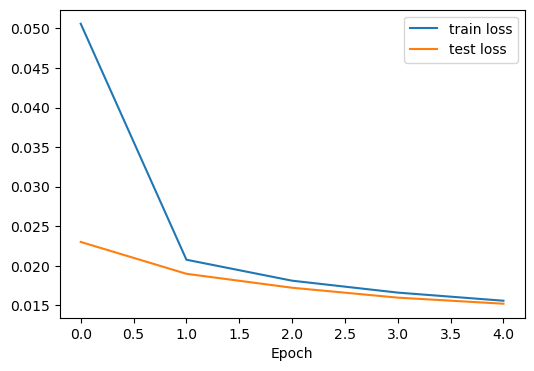

In [11]:
utils.plot_loss_curve(model_results)

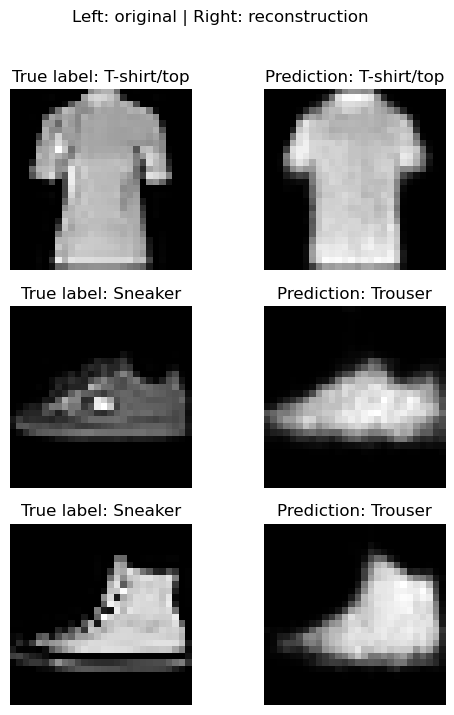

In [12]:
utils.plot_reconstructions(
    model = model, 
    dataset = test_dataset, 
    device = device, 
    class_names = class_names)

### 2.4. Analyze the output of the encoder after training. 

First, let's run the encoder for every element in `test_dataset` and store the outputs.

In [13]:
from tqdm.auto import tqdm

# Get number of encoder output neurons
encoder_output_size = encoder_output.shape[1]
encoder_outputs = []
for __ in range(encoder_output_size):
    encoder_outputs.append([])

# Prepare model for evaluation
model.eval()
with torch.inference_mode():
    # Loop over data in test_dataset
    for idx in tqdm(range(len(test_dataset))):
        # Get sample from test_dataset
        sample = test_dataset.__getitem__(idx)[0].unsqueeze(dim=0).to(device)
        # Forward pass through the encoder
        sample_encoder_output = model(sample, mode = "encoder").squeeze().cpu().numpy()
        # Append the results to `encoder_outputs`
        for j in range(len(sample_encoder_output)):
            encoder_outputs[j].append( sample_encoder_output[j] )
# Convert to numpy array
encoder_outputs = np.array(encoder_outputs)

# Generate color list based on encoder outputs. We will use it for scatter plots
color_list = []
for idx in range(len(test_dataset)):
    if test_dataset.__getitem__(idx)[1] == 0:
        color_list.append( "cornflowerblue" )
    elif test_dataset.__getitem__(idx)[1] == 1:
        color_list.append( "orange" )
    elif test_dataset.__getitem__(idx)[1] == 2:
        color_list.append( "limegreen" )
    elif test_dataset.__getitem__(idx)[1] == 3:
        color_list.append( "gray" )
    elif test_dataset.__getitem__(idx)[1] == 4:
        color_list.append( "violet" ) 
        
# Get lists of standard deviations for each neuron output
std_list = []
for idx in range(len(encoder_outputs)):
    std_list.append(np.std(encoder_outputs[idx]))
    
# Get list of sorted indices from std_list
sorted_idxs = np.argsort(std_list)

  0%|          | 0/5000 [00:00<?, ?it/s]

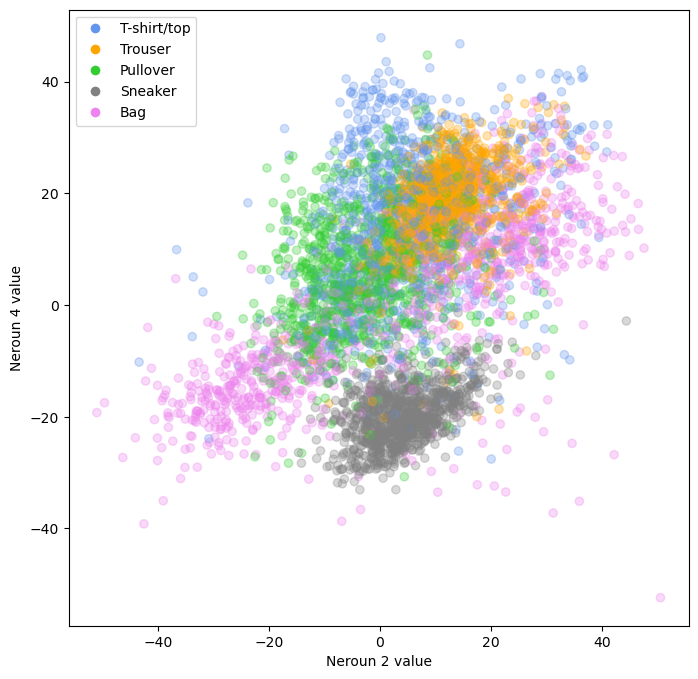

In [14]:
plt.figure(figsize = (8,8))
plt.scatter( encoder_outputs[sorted_idxs[0]], encoder_outputs[sorted_idxs[1]], 
            c = color_list, alpha = 0.3 )
plt.xlabel(f"Neroun {sorted_idxs[0]} value")
plt.ylabel(f"Neroun {sorted_idxs[1]} value")

legend_elements = [
    Line2D([0], [0], marker='o', color='white', label='T-shirt/top', markerfacecolor='cornflowerblue', markersize=8),
    Line2D([0], [0], marker='o', color='white', label='Trouser', markerfacecolor='orange', markersize=8),
    Line2D([0], [0], marker='o', color='white', label='Pullover', markerfacecolor='limegreen', markersize=8),
    Line2D([0], [0], marker='o', color='white', label='Sneaker', markerfacecolor='gray', markersize=8),
    Line2D([0], [0], marker='o', color='white', label='Bag', markerfacecolor='violet', markersize=8),
]
plt.legend(handles=legend_elements)

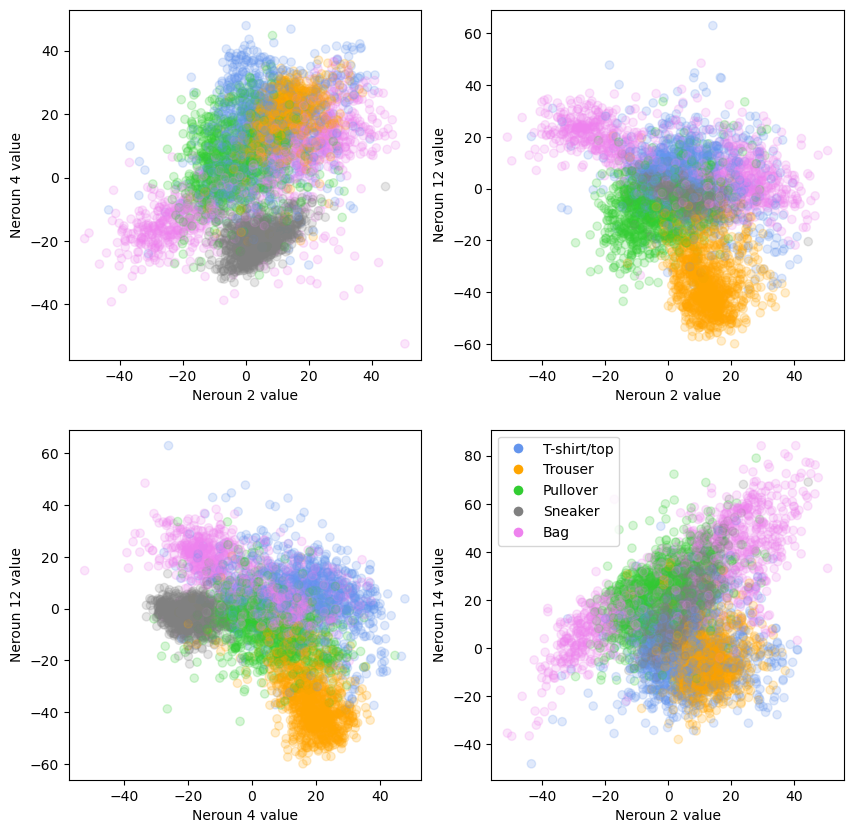

In [15]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
# Plot 1
index_1, index_2 = sorted_idxs[0], sorted_idxs[1]
axs[0,0].scatter( encoder_outputs[index_1], encoder_outputs[index_2], 
                c = color_list, alpha = 0.2 )
axs[0,0].set_xlabel(f"Neroun {index_1} value")
axs[0,0].set_ylabel(f"Neroun {index_2} value")
# Plot 2
index_1, index_2 = sorted_idxs[0], sorted_idxs[2]
axs[0,1].scatter( encoder_outputs[index_1], encoder_outputs[index_2], 
                c = color_list, alpha = 0.2 )
axs[0,1].set_xlabel(f"Neroun {index_1} value")
axs[0,1].set_ylabel(f"Neroun {index_2} value")
# Plot 3
index_1, index_2 = sorted_idxs[1], sorted_idxs[2]
axs[1,0].scatter( encoder_outputs[index_1], encoder_outputs[index_2], 
                c = color_list, alpha = 0.2 )
axs[1,0].set_xlabel(f"Neroun {index_1} value")
axs[1,0].set_ylabel(f"Neroun {index_2} value")
# Plot 4
index_1, index_2 = sorted_idxs[0], sorted_idxs[3]
axs[1,1].scatter( encoder_outputs[index_1], encoder_outputs[index_2], 
                c = color_list, alpha = 0.2 )
axs[1,1].set_xlabel(f"Neroun {index_1} value")
axs[1,1].set_ylabel(f"Neroun {index_2} value");
axs[1,1].legend(handles=legend_elements);

Hopefully, the trained network will develop clusters in the plots above.

## 4. Train the classifier

### 4.1. Prepare model for training

We will now freeze the `model.encoder` and `model.decoder` parts. We will also unfreeze the classifier head and prepare it for training.

In [16]:
# For some reason, I get errors here when I keep using CUDA. Hence, I move the model to CPU
device = "cpu"
model.to(device)

# Freeze encoder parameters
for parameter in model.encoder.parameters():
    parameter.requires_grad = False
# Freeze decoder parameters
for parameter in model.decoder.parameters():
    parameter.requires_grad = False
# Unfreeze classifier head
for parameter in model.classifier.parameters():
    parameter.requires_grad = True

summary(model)

Layer (type:depth-idx)                   Param #
CNN_Autoencoder                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       (160)
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       (2,320)
│    └─ReLU: 2-4                         --
│    └─Conv2d: 2-5                       (2,320)
│    └─ReLU: 2-6                         --
│    └─Conv2d: 2-7                       (4,112)
├─Sequential: 1-2                        --
│    └─ConvTranspose2d: 2-8              (4,112)
│    └─ReLU: 2-9                         --
│    └─ConvTranspose2d: 2-10             (2,320)
│    └─ReLU: 2-11                        --
│    └─ConvTranspose2d: 2-12             (2,320)
│    └─ReLU: 2-13                        --
│    └─ConvTranspose2d: 2-14             (145)
│    └─Sigmoid: 2-15                     --
├─Sequential: 1-3                        --
│    └─Flatten: 2-16                     --
│    └─Linear: 2-17                

### 4.2. Perform training

In [17]:
NUM_EPOCHS = 10

optimizer = torch.optim.Adam(params = model.parameters())
loss_fn = nn.CrossEntropyLoss()

classifier_training_results = engine.train(
    model = model,
    train_dataloader = train_dataloader, 
    test_dataloader = test_dataloader, 
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = NUM_EPOCHS,
    device = device,
    save_path = "classifier_models",
    model_mode = "classifier");

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.1614 | test_loss: 0.1432 
Epoch: 10 | train_loss: 0.1355 | test_loss: 0.1272 


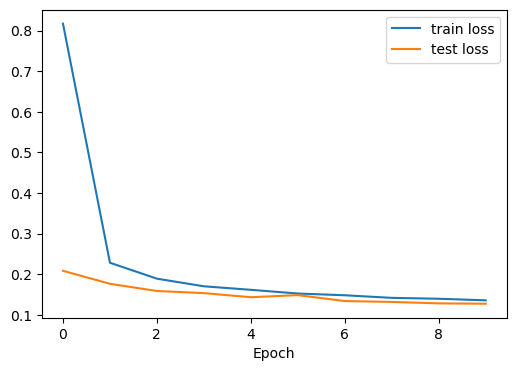

In [18]:
utils.plot_loss_curve(classifier_training_results)

## 5. Evaluate the final model

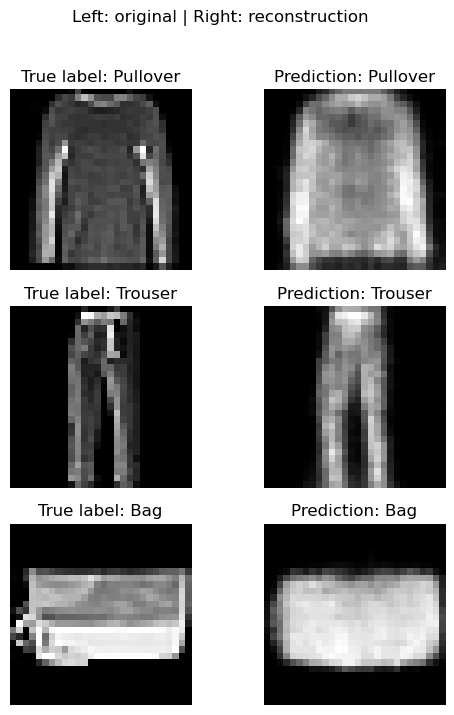

In [19]:
utils.plot_reconstructions(
    model = model, 
    dataset = test_dataset, 
    device = device, 
    class_names = class_names)

Accuracy = 0.965


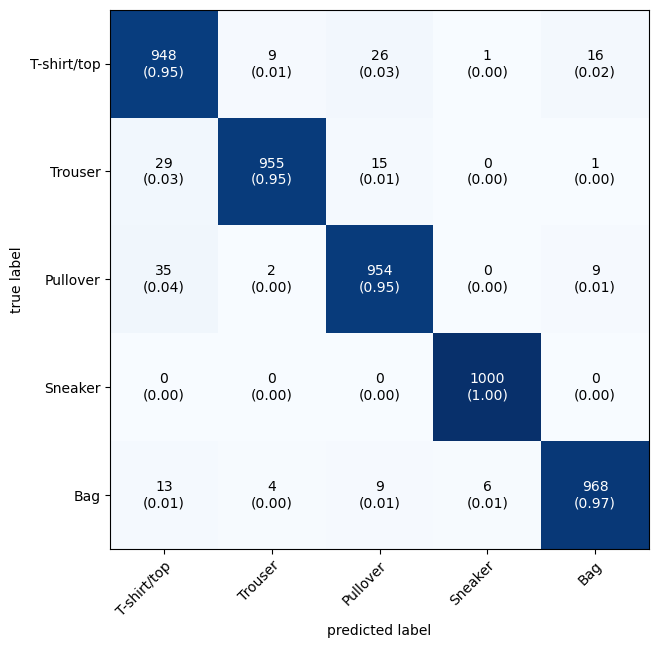

In [20]:
accuracy = utils.compute_confusion_matrix(
    model = model,
    dataset = test_dataset,
    device = device,
    class_names = class_names
)
print(f"Accuracy = {accuracy}")